In [73]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL

In [102]:
z=np.random.randn(100000, 1000)

In [104]:
%timeit z[np.random.permutation(100000)]

277 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
%timeit z[np.random.choice(range(100000), 5000, replace=False)]

33.6 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [106]:
%timeit np.random.choice(100000, 5000, replace=False)

1.9 ms ± 72.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [107]:
%timeit z[np.random.permutation(100000)]

267 ms ± 2.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
%timeit z[:]

267 ns ± 13.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [110]:
%timeit z[:5000]=np.random.randn(5000, 1000)

235 ms ± 6.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
1/20e-3

50.0

In [98]:
%timeit z[slice(-1)]

399 ns ± 19.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1', 'kc_dec', '5x5_1f1c1k_obs']

In [3]:
gin.bind_parameter('Config.collect_remotely', True)
gin.bind_parameter('Config.n_collectors', 30)
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.future_buffer_size', 50)
gin.bind_parameter('Normalizer.type_', 'meanstd')
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', True)
gin.bind_parameter('ExperienceReplayBuffer.buffer_limit_steps', 100000)
gin.bind_parameter('ExperienceReplayBuffer.minibatch_size', 5000)

In [4]:
ray.init(ignore_reinit_error=True)

2021-02-06 01:48:25,743	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.90.38.7',
 'raylet_ip_address': '10.90.38.7',
 'redis_address': '10.90.38.7:6379',
 'object_store_address': '/tmp/ray/session_2021-02-06_01-48-25_207013_32943/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-06_01-48-25_207013_32943/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-02-06_01-48-25_207013_32943',
 'metrics_export_port': 48015,
 'node_id': '02f2883d73682ecd71d3ef4c7ca7a95b5a3128bc'}

In [5]:
# gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
# gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [6]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [7]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-06 01:48:27,605	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 066c792c-6815-11eb-8ff1-90e2baa1a248
Make environment KeyChest-v0 None {}


In [8]:
learner.create_trainables()

In [9]:
learner.decoder

ModelDecoder(
  (model): FCNet(
    (fc01): Linear(in_features=847, out_features=512, bias=True)
    (fc02): Linear(in_features=512, out_features=30, bias=True)
  )
)

In [10]:
env = learner.env

In [11]:
losses = []
dclose = []
dfar = []

(pid=33238) Make environment KeyChest-v0 None {}
(pid=33206) Make environment KeyChest-v0 None {}
(pid=33240) Make environment KeyChest-v0 None {}
(pid=33241) Make environment KeyChest-v0 None {}
(pid=33207) Make environment KeyChest-v0 None {}
(pid=33185) Make environment KeyChest-v0 None {}
(pid=33182) Make environment KeyChest-v0 None {}
(pid=33220) Make environment KeyChest-v0 None {}
(pid=33222) Make environment KeyChest-v0 None {}
(pid=33230) Make environment KeyChest-v0 None {}
(pid=33204) Make environment KeyChest-v0 None {}
(pid=33202) Make environment KeyChest-v0 None {}
(pid=33201) Make environment KeyChest-v0 None {}
(pid=33215) Make environment KeyChest-v0 None {}
(pid=33243) Make environment KeyChest-v0 None {}
(pid=33212) Make environment KeyChest-v0 None {}
(pid=33236) Make environment KeyChest-v0 None {}
(pid=33187) Make environment KeyChest-v0 None {}
(pid=33208) Make environment KeyChest-v0 None {}
(pid=33210) Make environment KeyChest-v0 None {}
(pid=33225) Make env

In [21]:
opt = torch.optim.Adam(lr=5e-4, params=learner.decoder.parameters())

In [22]:
for i in tqdm(range(1000)):
    if i % 1 == 0:
        ctx = learner.collect_and_get_context()
    
    opt.zero_grad()
    l_obj = siamese_feature_discriminator_l2(**ctx)
    loss = l_obj['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())
    dclose.append(l_obj['metrics']['distance_close'])
    dfar.append(l_obj['metrics']['distance_far'])

(pid=31925) Make environment KeyChest-v0 None {}
(pid=31906) Make environment KeyChest-v0 None {}
(pid=31908) Make environment KeyChest-v0 None {}
(pid=31913) Make environment KeyChest-v0 None {}
(pid=31909) Make environment KeyChest-v0 None {}
(pid=31916) Make environment KeyChest-v0 None {}
(pid=31915) Make environment KeyChest-v0 None {}
(pid=31905) Make environment KeyChest-v0 None {}
(pid=31914) Make environment KeyChest-v0 None {}
(pid=31911) Make environment KeyChest-v0 None {}
(pid=31910) Make environment KeyChest-v0 None {}
(pid=31912) Make environment KeyChest-v0 None {}
(pid=31907) Make environment KeyChest-v0 None {}
(pid=31902) Make environment KeyChest-v0 None {}
(pid=31904) Make environment KeyChest-v0 None {}
(pid=31903) Make environment KeyChest-v0 None {}
(pid=10550) Make environment KeyChest-v0 None {}
(pid=10555) Make environment KeyChest-v0 None {}
(pid=10552) Make environment KeyChest-v0 None {}
(pid=10572) Make environment KeyChest-v0 None {}
(pid=10562) Make env

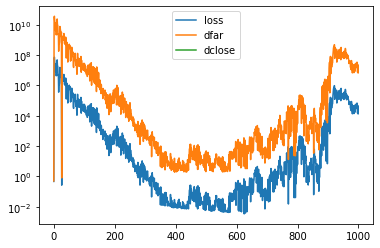

In [24]:
plt.plot(losses, label='loss')
plt.plot(dfar, label='dfar')
plt.plot(dclose, label='dclose')
plt.yscale('log')
plt.legend()

In [25]:
np.mean(losses[-50:]), np.median(losses[-50:])

(109043.7977734375, 66790.65625)

In [26]:
ctx = learner.collect_and_get_context()

In [27]:
features = learner.decoder(ctx['obs'])

In [28]:
f = features.detach().cpu().numpy()

In [29]:
f.shape

(5000, 30)

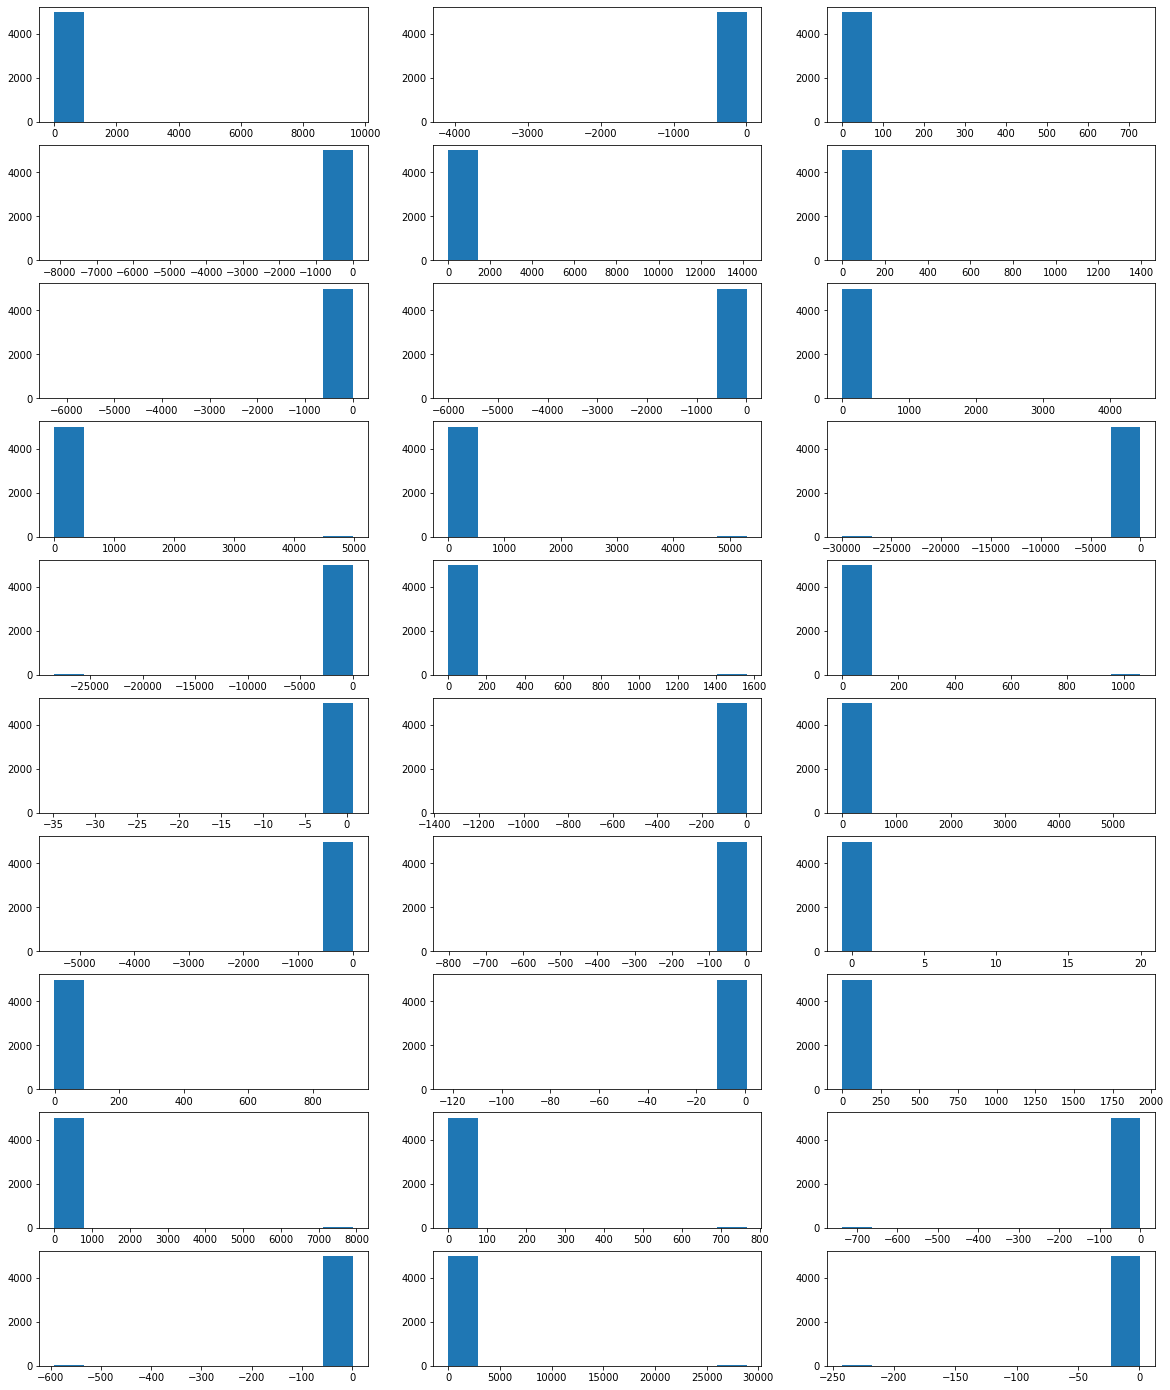

In [30]:
plt.figure(figsize=(20, 25))
for i_f in range(f.shape[1]):
    plt.subplot(10, 3, i_f + 1)
    plt.hist(f[:, i_f])

In [31]:
pd.DataFrame(f).std()

0      542.137878
1      231.199371
2       41.082676
3      460.690613
4      801.039612
5       78.858177
6      353.684082
7      338.950500
8      251.384750
9      281.366974
10     299.446716
11    1691.822266
12    1604.247437
13      88.140808
14      59.860813
15       1.969955
16      75.582680
17     310.816254
18     308.567291
19      45.245556
20       1.131442
21      52.169395
22       6.872755
23     108.990150
24     446.129791
25      43.259441
26      41.620308
27      33.492470
28    1630.263916
29      13.668118
dtype: float32

<AxesSubplot:>

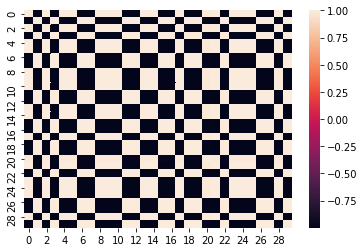

In [32]:
sns.heatmap(pd.DataFrame(f).corr())

In [33]:
env.engine.return_rgb = False

In [12]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.LeakyReLU)
gin.bind_parameter('model_gnn/FCCombinedModel.hidden_sizes', [100, 100, 100])

In [13]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [14]:
learner.non_sparse_model.model.model.activation

[LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 None]

In [15]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (bn): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [16]:
learner.non_sparse_model.model.enable_switch

False

In [17]:
mins = None
maxes = None

In [18]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [19]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        dim = 60
        self.bn = torch.nn.BatchNorm1d(num_features=34)
        self.fc1 = nn.Linear(in_features=34, out_features=dim)
        self.fc2 = nn.Linear(in_features=dim, out_features=dim)
        self.fc3 = nn.Linear(in_features=dim, out_features=dim)
        self.fc4 = nn.Linear(in_features=dim, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [20]:
losses = []
metrics = []
losses_emb = []
losses_fit = []
ctx_set = False

In [21]:
use_model = learner.non_sparse_model
#use_model = AdhocWorldModel().cuda()

In [22]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [23]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [24]:
opt = torch.optim.Adam(lr=1e-4, params=list(use_model.parameters())+list(learner.decoder.parameters()))

In [25]:
def fit_loss(obs_x, obs_y, action_x, decoder, model, additional_feature_keys,
             model_forward_kwargs=None,
             fill_switch_grad=False,
             opt_label=None,
             divide_by_std=False,
             std_eps=0.05,
             **kwargs):
    """Ensure that the model fits the features data."""

    if model_forward_kwargs is None:
        model_forward_kwargs = {}
    
    f_t1 = decoder(obs_y)#.detach()
        
    have_additional = False
    if additional_feature_keys:
        have_additional = True
        add_features_y = torch.cat([kwargs[k] for k in additional_feature_keys], dim=1)
        
        # WARNING: zeroing output features
#         f_t1 = torch.zeros_like(f_t1)
        f_t1 = torch.cat([f_t1, add_features_y], dim=1)
        
    # detaching second part like in q-learning makes the loss jitter

    f_t1_pred = model(decoder(obs_x), action_x, all=have_additional, **model_forward_kwargs)

    loss = (f_t1_pred - f_t1).pow(2)
    loss = loss.sum(1).mean()

    metrics = {'mean_feature': f_t1.mean(0).detach().cpu().numpy(),
               'std_feature': f_t1.std(0).detach().cpu().numpy(),
               'min_feature': f_t1.min().item(),
               'max_feature': f_t1.max().item(),
               #'std_feature_avg': f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0,
               #'inv_std_feature_avg': 1/f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0
              }

    return {'loss': loss,
            'metrics': metrics}

In [26]:
[x.mean() for x in learner.decoder.state_dict().values()]

[tensor(-8.2070e-06, device='cuda:0'),
 tensor(-0.0007, device='cuda:0'),
 tensor(-0.0003, device='cuda:0'),
 tensor(-0.0046, device='cuda:0')]

In [83]:
for i in tqdm(range(500000)):
    if i % 1 == 0 or not ctx_set:
        ctx_set = True
        ctx = learner.collect_and_get_context()
        
#         if mins is None or maxes is None:
#             print("Computing minmax")
#             f_all = learner.decoder(ctx['obs'])
#             mins = f_all.min(dim=0, keepdim=True).values.detach()
#             maxes = f_all.max(dim=0, keepdim=True).values.detach()
        
#         f_t1 = learner.decoder(ctx['obs_y'])#.detach()
#         f_t = learner.decoder(ctx['obs_x'])#.detach()
        
# #         f_t1 = normalize(f_t1, mins, maxes)
# #         f_t = normalize(f_t, mins, maxes)
        
#         add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
#         f_t1 = torch.cat([f_t1, add_features_y], dim=1)
        
#     f_t1_pred = use_model(
#         f_t,
#         ctx['action_x'],
#         all=True)
    
    ctx['non_sparse_model_add'] = use_model
#     ctx['additional_feature_keys'] = []
    l_obj_emb = siamese_feature_discriminator_l2(**ctx)
    l_obj_fit = context_rewriter(function=fit_loss, rewrite={'model': 'non_sparse_model_add'},
                                 divide_by_std=False,
                                 **ctx)
    loss = l_obj_fit['loss'] + l_obj_emb['loss']

    
#     loss = nn.MSELoss()(f_t1, f_t1_pred)

    
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    losses_emb.append(l_obj_emb['loss'].item())
    losses_fit.append(l_obj_fit['loss'].item())
    m = {}
    m.update(l_obj_fit['metrics'])
    m.update(l_obj_emb['metrics'])
    metrics.append(m)

KeyboardInterrupt: 

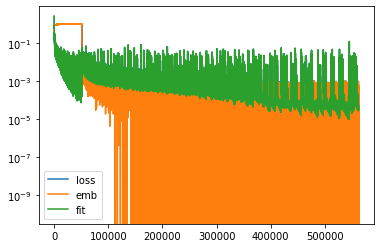

In [66]:
plt.plot(losses, label='loss')
plt.plot(losses_emb, label='emb')
plt.plot(losses_fit, label='fit')
#plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [67]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [68]:
%load_ext jupyternotify
%autonotify -a 30

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [69]:
f_t1 = learner.decoder(ctx['obs_y'])#.detach()
f_t = learner.decoder(ctx['obs_x'])#.detach()

#         f_t1 = normalize(f_t1, mins, maxes)
#         f_t = normalize(f_t, mins, maxes)

add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
# f_t1 = torch.zeros_like(f_t1)
f_t1 = torch.cat([f_t1, add_features_y], dim=1)

f_t1_pred = use_model(
f_t,
ctx['action_x'],
all=True)


<AxesSubplot:>

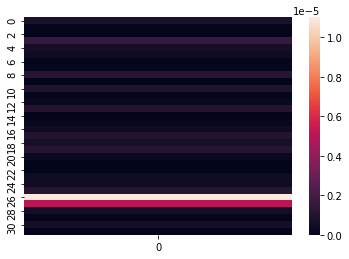

In [71]:
sns.heatmap((f_t1_pred - f_t1).pow(2).mean(0).cpu().detach().numpy().reshape(-1, 1), vmin=0)

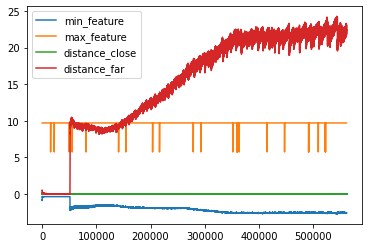

In [72]:
metrics_dct = lstdct2dctlst(metrics)
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.legend()
plt.show()

In [48]:
metrics_dct.keys()

dict_keys(['mean_feature', 'std_feature', 'min_feature', 'max_feature', 'distance_plus', 'distance_minus'])

In [49]:
losses[-1]

0.018160220235586166

In [50]:
learner.decoder(ctx['obs_x']).min()

tensor(-0.2716, device='cuda:0', grad_fn=<MinBackward1>)

In [51]:
# metrics_dct['']